In [25]:
from efficientnet_pytorch import EfficientNet 
from torchsummary import summary
import torch
import cv2
from  torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [26]:

model =EfficientNet.from_name('efficientnet-b0')
model.load_state_dict(torch.load(r'C:\Users\DELL\Desktop\pytorch_pre\efficientnet-b0-355c32eb.pth'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model=model.eval()

In [27]:
def img_preprocess(img_in):
    img = img_in.copy()
    img = img[:, :, ::-1]  
    img = np.ascontiguousarray(img)	
    img = Image.fromarray(img) 
    # 2
    transform = transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = transform(img)
    img = img.unsqueeze(0)
    return img

def cam_show_img(img, feature_map, grads, out_dir):
    H, W, _ = img.shape
    cam = np.zeros(feature_map.shape[1:], dtype=np.float32)
    grads = grads.reshape([grads.shape[0],-1])
    weights = np.mean(grads, axis=1)
    for i, w in enumerate(weights):
        cam += w * feature_map[i, :, :]
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    cam = cv2.resize(cam, (W, H))

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    cam_img = 0.3 * heatmap + 0.7 * img

    path_cam_img = os.path.join(out_dir, "cam.jpg")
    cv2.imwrite(path_cam_img, cam_img)

(377, 400, 3)

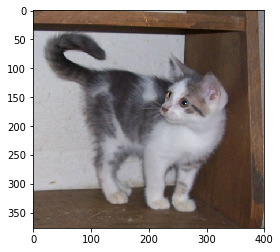

In [28]:
img_path =r'C:\Users\DELL\Desktop\pytorch_pre\CAT_DOG\data\Cat\299.jpg'
img =cv2.imread(img_path,1)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
img.shape

In [29]:
f_map =list()
f_grad=list()
def backward_bn(module,grad_input,grad_output):
    f_grad.append(grad_output[0].detach())
def forward_bn(module,data_input,data_output):
    f_map.append(data_output)
model._bn1.register_forward_hook(forward_bn)
model._bn1.register_backward_hook(backward_bn)

In [30]:
img_input =img_preprocess(img)
out =model(img_input.to(device))
idx = np.argmax(out.cpu().data.numpy())
class_loss = out[0,idx]
class_loss.backward()

In [31]:
print(f_grad[0].shape)
print(f_map[0].shape)
grads_val = f_grad[0].cpu().data.numpy().squeeze()
fmap = f_map[0].cpu().data.numpy().squeeze()

torch.Size([1, 1280, 7, 7])
torch.Size([1, 1280, 7, 7])


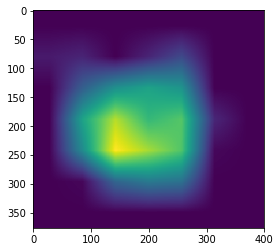

In [32]:
# 计算grad-cam并可视化
H, W, _ = img.shape
cam = np.zeros(fmap.shape[1:], dtype=np.float32)
grads = grads_val.reshape([grads_val.shape[0],-1])
weights = np.mean(grads, axis=1)
for i, w in enumerate(weights):
    cam += w * fmap[i, :, :]
cam = np.maximum(cam, 0)
cam = cam / cam.max()
cam = cv2.resize(cam, (W, H))
plt.imshow(cam)

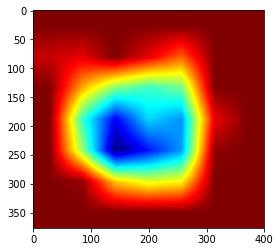

In [33]:
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
# cam_img = 0.3 * heatmap + 0.7 * img
plt.imshow(heatmap)

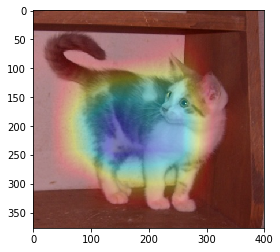

In [34]:
cam_img = np.uint8(0.3 * heatmap + 0.7*img)
plt.imshow(cam_img)